In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import torch

DATASETS = '../datasets/'

def read_file(dir_name):
    main_df = pd.DataFrame()
    directory = DATASETS + dir_name
    for filename in os.listdir(directory):
        data = np.load(os.path.join(directory, filename))
        data_dict = {}
        for keys in data.keys():
            data_dict[keys] = list(data[keys])
        df = pd.DataFrame.from_dict(data_dict)
        main_df = pd.concat([main_df, df])
    return main_df

In [2]:
data = []
for name in os.listdir("../datasets/mw"):
    inner_df = pd.DataFrame()
    if not (name.startswith('.')):
        dir_name = 'mw/'+name
        print(dir_name)
        df = read_file(dir_name)
        inner_df = pd.concat([inner_df, df])    
    data.append(inner_df)
data = np.array(data, dtype=object)


mw/cls_sweep-v2
mw/cls_push-v2
mw/cls_door-open-v2
mw/cls_peg-insert-side-v2
mw/cls_drawer-close-v2
mw/cls_basketball-v2
mw/cls_reach-v2
mw/cls_window-open-v2
mw/cls_pick-place-v2
mw/cls_button_press_topdown-v2


# MAIN CODE

In [36]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import warnings
import copy
import matplotlib.pyplot as plt
import random
import math
from torch.nn import functional as F
warnings.filterwarnings('ignore')


class MetaRewardMLPEnsemble(nn.Module):
    def __init__(
        self,
        hidden_layers=[256, 256, 256],
        # ensemble_size=3,
        act=F.leaky_relu,
        output_act=torch.tanh,
    ):
        super().__init__()
        params = {}
        last_dim = 39 + 4
        self.num_layers = len(hidden_layers) + 1
        for i, dim in enumerate(
            hidden_layers
            + [
                1,
            ]
        ):
            weight = torch.empty(last_dim, dim)
            weight.transpose_(0, 1)
            nn.init.kaiming_uniform_(weight, a=math.sqrt(5))
            weight.transpose_(0, 1)
            params[f"linear_w_{i}"] = nn.Parameter(weight)
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(params[f"linear_w_{i}"].T)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            params[f"linear_b_{i}"] = nn.Parameter(
                nn.init.uniform_(torch.empty(1, dim, requires_grad=True), -bound, bound)
            )
            last_dim = dim

        self.params = nn.ParameterDict(params)
        self.parameters = self.params.parameters ######### NEW
        # self.ensemble_size = ensemble_size
        self.act = act
        self.output_act = output_act

    def forward(self, x, params=None):
        if params is None:
            params = self.params
        # x = torch.cat((obs, action), dim=1)
        # x = x.repeat(self.ensemble_size, 1, 1)
        for i in range(self.num_layers):
            # print('b_0: ', params[f"linear_b_{i}"].repeat(n_x, 1).shape)
            # print('x:', x.shape)
            # print('w_0: ', params['linear_w_0'].shape)
            # x = torch.baddbmm(params[f"linear_b_{i}"], x, params[f"linear_w_{i}"])
            # print(params)
            x = params[f"linear_b_{i}"] + torch.matmul( x, params[f"linear_w_{i}"] )
            if i == self.num_layers - 1:
                x = self.output_act(x)
            else:
                x = self.act(x)
        return x.squeeze(-1)


# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1=256, hidden_size2=256, hidden_size3=256, output_size = 2750):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.out = nn.Linear(hidden_size2, 1)
    
#     # def forward_inner(self, x, parameters):
#     #     x = torch.relu(self.fc1(x, parameters['fc1.weight'], parameters['fc1.bias']))
#     #     x = torch.relu(self.fc2(x, parameters['fc2.weight'], parameters['fc2.bias']))
#     #     x = torch.tanh(self.out(x, parameters['out.weight'], parameters['out.bias']))
#     #     return x
#     def forward(self, x):
#         # print(x.shape)
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.tanh(self.out(x))
#         return x
    
#     def para_forw(self, x, param):
#         # print(param['fc1.weight'].shape)
#         x = torch.relu(nn.functional.linear(x, param['fc1.weight'], param['fc1.bias']))
#         x = torch.relu(nn.functional.linear(x, param['fc2.weight'], param['fc2.bias']))
#         x = torch.tanh(nn.functional.linear(x, param['out.weight'], param['out.bias']))
        # return x


class PreferenceMAML:
    def __init__(
        self,
        ml10,
        input_size,
        hidden_size1,
        hidden_size2,
        outer_lr = 1e-7,
        inner_lr = 0.001,
        num_support=10,
        num_query=10,
        num_inner_steps=5,
        k = 25,
        num_tasks = 10,
        episode_per_task = 1250,
        output_size = 2750,
        **kwargs,
    ):
        self.ml10 = ml10
        self.reward_criterion =  nn.BCELoss()
        self.num_support = num_support
        self.num_query = num_query
        self.num_inner_steps = num_inner_steps
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.k = k
        self.num_tasks = num_tasks
        self.episode_per_task = episode_per_task
        self.num_segments = None
        self.model = MetaRewardMLPEnsemble()


    def construct_episodes(self, ml10):
        # episodes - n (tasks) x num_episode (each npz file)  , each cell is a dataframe of the episode 
        self.episodes = []
        for task in ml10:
            if(len(task)==0):
                continue
            task_episodes=[]
            row_index = task[task['done'] == True].index.tolist()
            prev=0
            for x in row_index:
                task_episodes.append(task[prev:x+1])
                prev=x+1
            task_episodes = np.array(task_episodes,dtype=object)
            self.episodes.append(task_episodes)
        self.episodes = np.array(self.episodes,dtype=object)
        # return episodes

    def form_sigma_groups(self, episode):
        #num_segments = int(episode.shape[0] / self.k)
        split_indices = np.arange(self.k, episode.shape[0], self.k)
        # print(num_segments)
        if len(split_indices) != 0:
            l_segment = np.array_split(episode.iloc[::-1][:(self.k*(episode.shape[0] // self.k))], split_indices)
            for i in range(len(l_segment)):
                l_segment[i] = l_segment[i].iloc[::-1]
            if(len(l_segment[-1])<25):
                l_segment=l_segment[:-1]
            return l_segment
        else:
            return None

    def compare_probabilities(self, sigma1, sigma2):
        exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
        exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
        prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
        return [0] if prob > 0.5 else [1]

    def prepare_data(self):
        X = []
        y = []
        episodes = self.episodes
        # sigmas = self.form_sigma_groups(episodes, k)
        sigmas = []
        for task in episodes:
            sigma = []
            for episode in task:
                segment = self.form_sigma_groups(episode)
                # print(len(segment))
                if segment is not None:
                    sigma.append(segment)
            # sigma = [self.form_sigma_groups(episode, k) for episode in task]
            sigmas.append(sigma)
        sigmas = np.array(sigmas, dtype=object)
        all_lengths = [len(episode) for task in sigmas for episode in task]
        self.num_segments = min(all_lengths)
        if(self.num_segments<3):
            self.num_segments=3
        for task in sigmas:
            task_list=[]
            for episode in task:
                ep_list=[]
                if(len(episode)<self.num_segments):
                    continue
                for i in range(self.num_segments):
                    y.append(episode[i]["reward"])
                    ep_list.append(episode[i].drop('reward', axis=1))
                task_list.append(ep_list)
            task_list=np.array(task_list, dtype=object).reshape(-1,1) # convert row vector to col vector
            X.append(task_list)
        X_new=[]
        task_counter = []
        for task in X:
            counter = 0
            for i in range(0,len(task),4):
                X_new.append(np.concatenate((task[i][0], task[i+1][0])))
                counter += 1
            task_counter.append(counter)
        X = np.array(X_new, dtype=object)
        task_counts = np.array(task_counter, dtype=object)
        y=np.array(y,dtype=object)
        y=y.flatten()
        return X, y, task_counts
    
    def batchify(self, X, y, task_lengths, task_no, num=110):
        # print(task_no)
        if task_no == 0:
            task_beg = 0  
            task_end = task_lengths[0]
        else:    
            task_beg = np.sum(task_lengths[0:task_no])    
            task_end = np.sum(task_lengths[0:task_no+1])
        rand = random.sample(range(0,400), 110)
        X_task = X[task_beg:task_end]
        y_task = y[task_beg:task_end]
        X_random = []
        y_random = []
        for r in rand:
            X_random.append(X_task[r*25 : r*25+25])
            y_random.append(y_task[r*25 : r*25+25])
        X_random = np.array(X_random, dtype=np.float32)
        y_random = np.array(y_random, dtype=np.float32)
        return X_random.reshape(2750,43), y_random.reshape(2750,)
    







    def train(self, X, y, task_lengths, num_epochs):
        # optimizer = optim.Adam(self.model.params.values(), lr = self.outer_lr) ######### self.model.parameters() self.model.params.values()
        # optimizer.zero_grad()
        # self.optim["reward"].zero_grad()
        # print(self.model.state_dict())
        # print(self.model.parameters())
        plt_x = np.arange(0, num_epochs)
        plt_y = np.zeros(num_epochs)
        for epoch in tqdm(range(num_epochs)):
            # optimizer.zero_grad()
            loss = self._outer_step(self.model, X, y, task_lengths) 
            if loss is None:
                return {}
            # print('loss from train:', loss)
            plt_y[epoch] = loss
            # print("Train Loss 1: ",plt_y[epoch])
            # print("Train loss 2: ", loss)

            #######################################
            #######################################

            # for k, val in self.model.params.items():
                # print(k)
                # print(val)
            
            grads = torch.autograd.grad(loss, self.model.params.values(), create_graph=True)

            # print(grads) ####### 2nd epoch onwards all 0. EVEN AFTER reducing the outer_lr to 1e-7

            idx = 0
            # new_dict = {}
            for name, w in self.model.params.items():
                # print(name)
                if name in ['linear_b_0', 'linear_b_1', 'linear_b_2', 'linear_b_3']:
                    # print('B:', name)
                    # print('INIT PARAMS- -------')
                    # print(self.model.params[name])

                    self.model.params[name] = self.model.params[name] - 0.0001 * grads[idx]
                    
                    # print('GRADS --------')
                    # print(grads[idx])

                    # print('lr * GRADS --------')
                    # print(0.0001)
                    # print(0.0001* grads[idx])
                else:
                    # print('L:', name)
                    # print('INIT PARAMS  -----------')
                    self.model.params[name] = self.model.params[name] - 0.0001 * grads[idx]
                    # print('GRADS ---------')
                    # print(grads[idx])

                    # print('lr * GRADS --------')
                    # print(0.0001)
                    # print(0.0001 * grads[idx])
                    
                # self.model.params[name] = self.model.params[name] - self.outer_lr * grads[idx][0]
                # raise Exception
                idx += 1
                # w.copy_(w_prime)
                # new_dict[name] = w_prime
            # return new_dict
            #######################################
            #######################################
            

            if epoch % 100 == 0:
                plt.plot(plt_x[:epoch+1], plt_y[:epoch+1])
                plt.xlabel("Epochs")
                plt.ylabel("Mean Loss")
                plt.show() 
                print(f"Epoch: {epoch}, Loss: {plt_y[epoch]}")
            
            # print(loss.grad)
            # loss.backward()
            # optimizer.step()
            # self.optim["reward"].step()
        # return plt_y


    def _outer_step(self, model, X, y, task_lengths):
        outer_losses = []
        for t in range(self.num_tasks):
            X_b, y_b = self.batchify(X, y, task_lengths, t)
            H, W = X_b.shape
            inner_x = X_b[:H//2, :]
            inner_y = y_b[:H//2]
            outer_x = X_b[H//2:, :]
            outer_y = y_b[H//2:]
            weights = self._inner_loop(inner_x, inner_y, model = model)
            # model_outer = copy.deepcopy(model)
            # model_outer = Model(43, 256, 256, 256)
            # model_outer.load_state_dict(weights)
            # model_outer.load_state_dict(weights)
            outer_losses.append(self._compute_loss(outer_x, outer_y, model, parameters=weights))
        # print(outer_losses)
        if (len(outer_losses) == 0):
            return None
        outer_loss = torch.mean(torch.stack(outer_losses))
        # print("Outer Loss: ", loss)
        return outer_loss


            
    def _inner_loop(self, X, y, model):
        # parameters = {k: torch.clone(v) for k, v in model.ParameterDict()}
        # model_inner = copy.deepcopy(model)
        # opt_inner = optim.SGD(model_inner.parameters(), lr = self.inner_lr)
        # state_dict = model.state_dict()
        # print(id(model.parameters()))
        # print(id(model.params))
        # print(model.state_dict())
        params_og = model.params
        new_dict = {k: torch.clone(v) for k, v in params_og.items()} ######### state_dict
        

        # print(new_dict)                                                        ######### IN 2nd EPOCH SOMEHOW new_dict has values {new_dict from 1st epoch +/- 256}


        loss = self._compute_loss(X, y, model, parameters = new_dict)
        # print("Loss computed")
        # grad = torch.autograd.grad(loss, parameters, allow_unused=True)
        # for name, w in model_inner.named_parameters():
        #     print(name, w)
        # print('loss from inner:',loss)

        grad = torch.autograd.grad(loss, new_dict.values(), create_graph=True)

        # grad = []
        # # print(new_dict.values().requires_grad)
        # for val in new_dict.values():
        #     # print(val)
        #     # val.requires_grad = True
        #     # print(val.requires_grad)
        #     grad.append(torch.autograd.grad(loss, val, create_graph=True))
            # print("Gradient")
            # print(grad)
            # raise Exception
        # print("Grad: ")
        # print(grad)
        # print(len(grad))
        # raise Exception
        # print(len(grad))
        
        # print(grad)

        idx = 0
        for name, w in params_og.items():
            # print(name)
            if name in ['linear_b_0', 'linear_b_1', 'linear_b_2', 'linear_b_3']:
                # print('B:', name)
                new_dict[name] = new_dict[name] - 0.001 * grad[idx]
                # print(grads[idx])
            else:
                # print('L:', name)
                new_dict[name] = new_dict[name] - 0.001 * grad[idx]
                # print(grads[idx])
                
            # self.model.params[name] = self.model.params[name] - self.outer_lr * grads[idx][0]
            # raise Exception
            idx += 1

        # idx = 0
        # # new_dict = {}

        
        # for name, w in params_og.items():
        #     # print(grad[idx][0])
        #     new_dict[name] = new_dict[name] - self.inner_lr * grad[idx][0]
        #     # raise Exception
        #     idx += 1
            # w.copy_(w_prime)
            # new_dict[name] = w_prime
        return new_dict
        # for name, w in model_inner.named_parameters():
        #     print(name, w)
        # raise Exception
        # weights = list(map(lambda p: p[1] - self.inner_lr * p[0], zip(grad, parameters)))
        # print(weights)

        # print("Inner loss: ", loss)
        # opt_inner.zero_grad()
        # loss.backward()
        
        # opt_inner.step()

        # grads = torch.autograd.grad(loss, parameters, create_graph=True)
        #for j,k in enumerate(parameters.keys()):
         #   parameters[k] = parameters[k] - self.inner_lr * grads[j]
        # for name, w in model_inner.named_parameters():
        #     if 'weight' in name:
        #         w = w - self.inner_lr * grads

        # parameters = parameters - self.inner_lr * grads
        # return weights

    '''
    R_E = 
    [
        [
            sigma_s1^E1, ..., sigma_s#^E1
        ],
        [
            sigma_s1^E2, ..., sigma_s#^E2
        ], ...,
        [
            sigma_s1^EN, ..., sigma_s#^EN
        ]
    ]
    '''
    #self.k = segment lenght
    def _compute_loss(self, X, y, model, parameters = None):
        # print(X, y, X.shape, y.shape)
        # state_dict = model.state_dict()
        # if parameters is not None:
        #     model.load_state_dict(parameters)
        
        X_tensor = torch.from_numpy(X)
        y_tensor = torch.from_numpy(y)
        if parameters is not None:
            output_reward = model.forward(X_tensor, parameters) # WORKING
        else:
            print('Params are NONE')
            output_reward = model(X_tensor)
        # N_o, _ = output_reward.shape
        # print(output_reward.shape)
        x =  y_tensor.shape[0]
        N = x//self.k
        output_reward = output_reward.reshape(N, self.k)
        output_reward = torch.sum(output_reward, dim=1)
        y_tensor = y_tensor.reshape(N, self.k)
        y_tensor = torch.sum(y_tensor, dim=1)
        loss = 0
        criterion = nn.BCEWithLogitsLoss()
        #out_mat = np.exp(out_mat)
        # out_logit = []
        # out_y = []
        loss = []
        for i in range(N):
            # sig_1 = output_reward[i]
            # y_1 = y_tensor[i]
            for j in range(i+1, N):
                # sig_2 = output_reward[j]
                # y_2 = y_tensor[j]
                if y_tensor[i] > y_tensor[j]:
                    loss.append(criterion(output_reward[j] - output_reward[i], torch.tensor(0.0, requires_grad= True)))
                else:
                    loss.append(criterion(output_reward[j] - output_reward[i], torch.tensor(1.0, requires_grad= True)))

        loss = torch.mean(torch.stack(loss)) #### sum
        # if parameters is not None:
        #     model.load_state_dict(state_dict)
        return loss
 # for i in range(N):
        #     # print(torch.sum(output_reward[i*self.k:(i+1)*self.k]).detach().numpy())
        #     out_mat[i, :] = torch.sum(output_reward[i*self.k:(i+1)*self.k]).detach().numpy()
        #     y_mat[i, :] = torch.sum(y_tensor[i*self.k:(i+1)*self.k]).detach().numpy()
  # if (model is not None) and (parameters is not None) :
        #     print("Errors")
        #     return
        # if model is not None:  
        #     output_reward = model(X_tensor)
        # elif parameters is not None:
        #     output_reward = self.model(X_tensor, parameters)
        # else:
        #     output_reward = self.model(X_tensor)
################################################################################################
################################################################################################
################################################################################################

ml10 = data.copy()  
input_size = 43  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
hidden_size1 = 256
hidden_size2 = 256
hidden_size3 = 256
# hidden_size3 = 1024
# hidden_size4 = 2075

output_size = 1
num_epochs = 5
outer_lr = 0.0001

model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, hidden_size3)
# model.setup_optimizers(optim.Adam, {"lr": outer_lr})

model.construct_episodes(ml10)
print('Preparing Data.')



Preparing Data.


In [27]:
X, y, task_lengths = model.prepare_data()
print('Data Preparation Done.\n')

Data Preparation Done.



  0%|                                                  | 0/5000 [00:00<?, ?it/s]

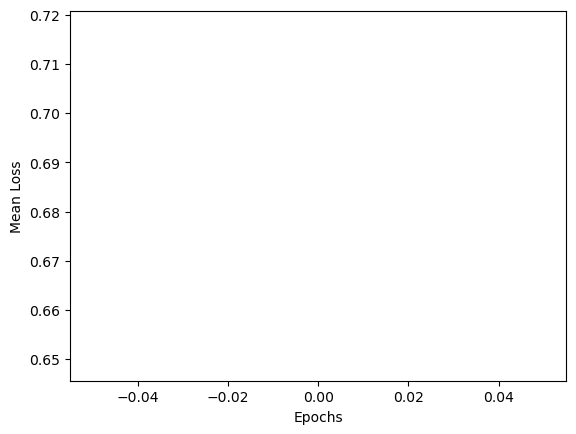

  0%|                                        | 1/5000 [00:04<5:35:02,  4.02s/it]

Epoch: 0, Loss: 0.6831754446029663


  2%|▊                                     | 100/5000 [08:05<6:35:56,  4.85s/it]

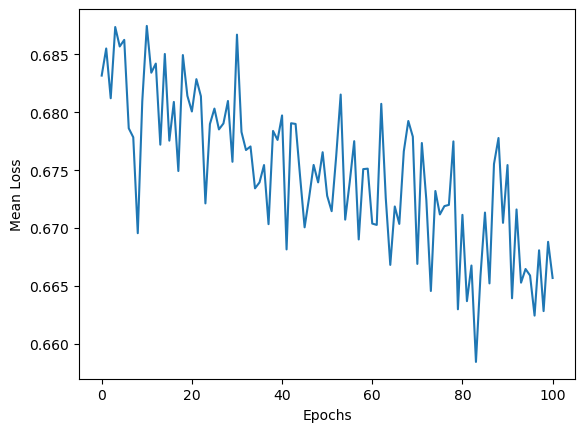

  2%|▊                                     | 101/5000 [08:10<6:35:10,  4.84s/it]

Epoch: 100, Loss: 0.6656779646873474


  4%|█▌                                    | 200/5000 [16:05<6:16:38,  4.71s/it]

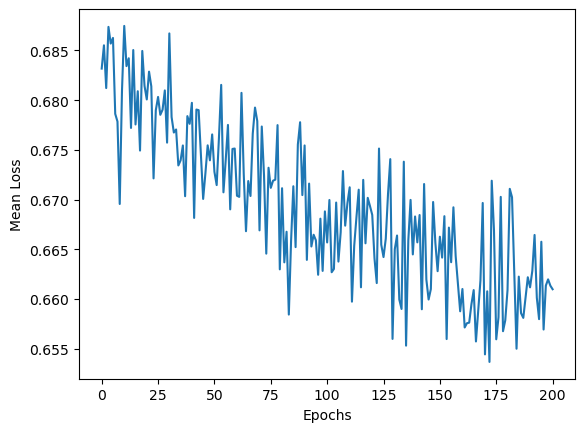

  4%|█▌                                    | 201/5000 [16:10<6:17:32,  4.72s/it]

Epoch: 200, Loss: 0.6609705090522766


  6%|██▎                                   | 300/5000 [24:09<6:15:43,  4.80s/it]

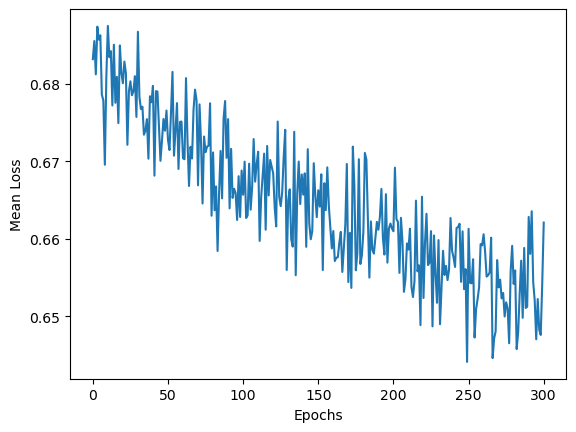

  6%|██▎                                   | 301/5000 [24:14<6:17:04,  4.81s/it]

Epoch: 300, Loss: 0.6620889902114868


  8%|███                                   | 400/5000 [32:20<6:14:16,  4.88s/it]

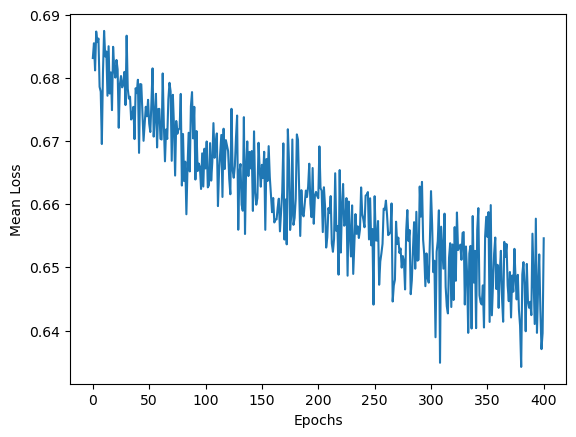

  8%|███                                   | 401/5000 [32:25<6:13:34,  4.87s/it]

Epoch: 400, Loss: 0.6546138525009155


 10%|███▊                                  | 500/5000 [40:28<6:19:59,  5.07s/it]

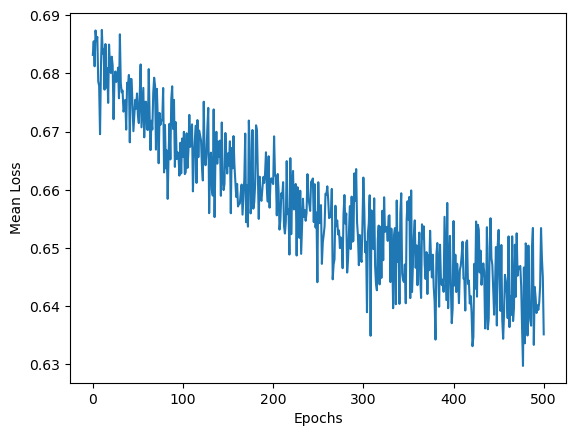

 10%|███▊                                  | 501/5000 [40:34<6:35:50,  5.28s/it]

Epoch: 500, Loss: 0.6351338624954224


 12%|████▎                               | 600/5000 [2:18:54<5:51:22,  4.79s/it]

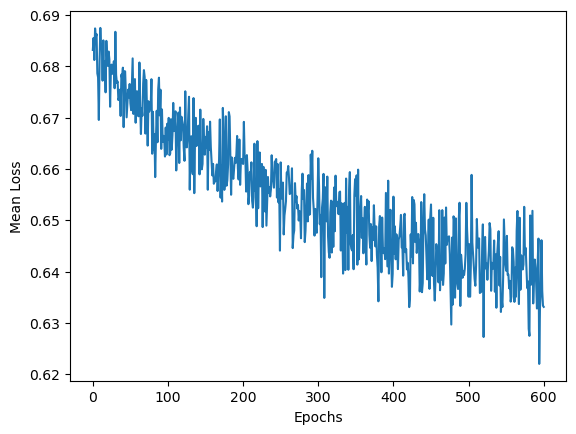

 12%|████▎                               | 601/5000 [2:18:59<5:55:36,  4.85s/it]

Epoch: 600, Loss: 0.6331493258476257


 14%|█████                               | 700/5000 [2:26:56<5:42:10,  4.77s/it]

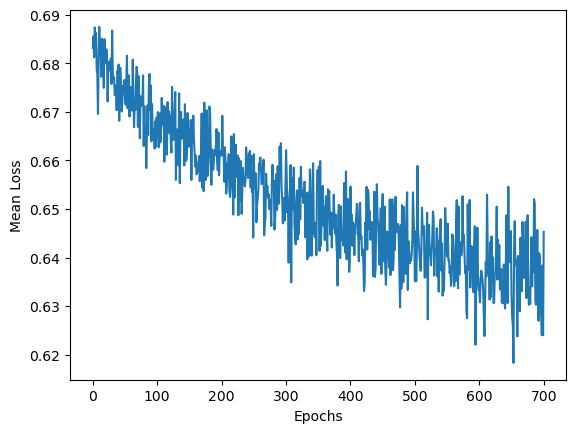

 14%|█████                               | 701/5000 [2:27:01<5:44:29,  4.81s/it]

Epoch: 700, Loss: 0.6452826261520386


 16%|█████▊                              | 800/5000 [2:34:56<5:34:53,  4.78s/it]

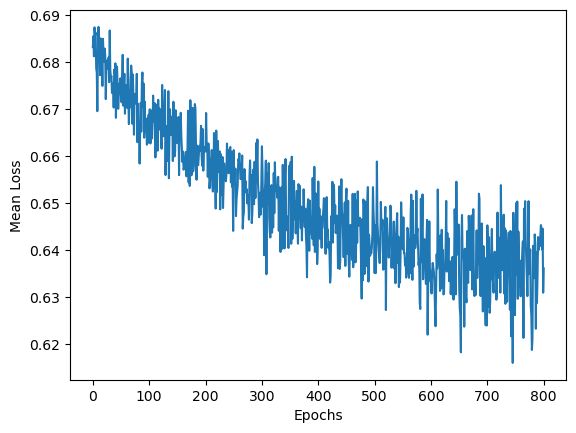

 16%|█████▊                              | 801/5000 [2:35:01<5:38:01,  4.83s/it]

Epoch: 800, Loss: 0.6361414194107056


 18%|██████▍                             | 900/5000 [2:42:58<5:29:43,  4.83s/it]

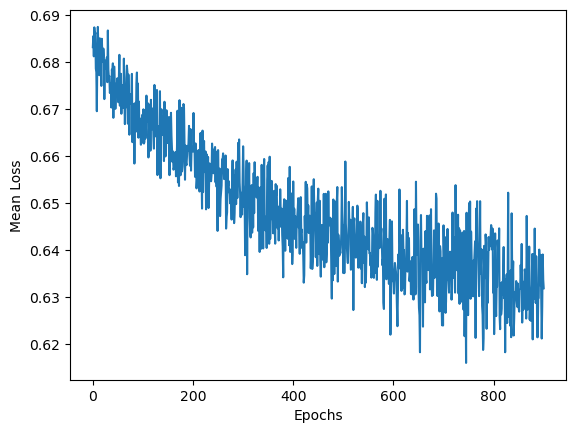

 18%|██████▍                             | 901/5000 [2:43:03<5:28:50,  4.81s/it]

Epoch: 900, Loss: 0.6319011449813843


 20%|███████                            | 1000/5000 [2:51:02<5:24:01,  4.86s/it]

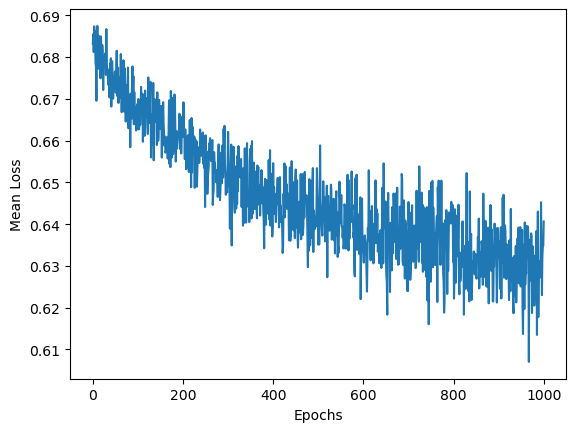

 20%|███████                            | 1001/5000 [2:51:07<5:22:46,  4.84s/it]

Epoch: 1000, Loss: 0.6406364440917969


 22%|███████▋                           | 1100/5000 [2:59:05<5:13:52,  4.83s/it]

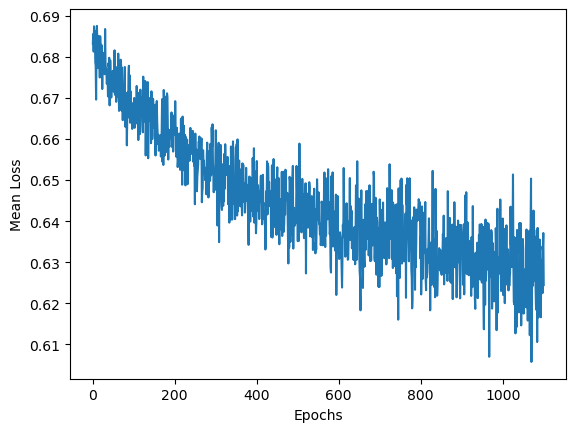

 22%|███████▋                           | 1101/5000 [2:59:09<5:13:04,  4.82s/it]

Epoch: 1100, Loss: 0.6244404315948486


 24%|████████▍                          | 1200/5000 [3:07:07<5:05:20,  4.82s/it]

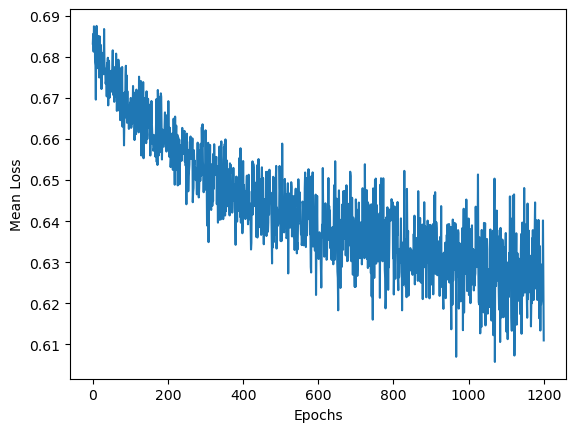

 24%|████████▍                          | 1201/5000 [3:07:12<5:05:04,  4.82s/it]

Epoch: 1200, Loss: 0.6109872460365295


 26%|█████████                          | 1300/5000 [3:15:11<5:15:44,  5.12s/it]

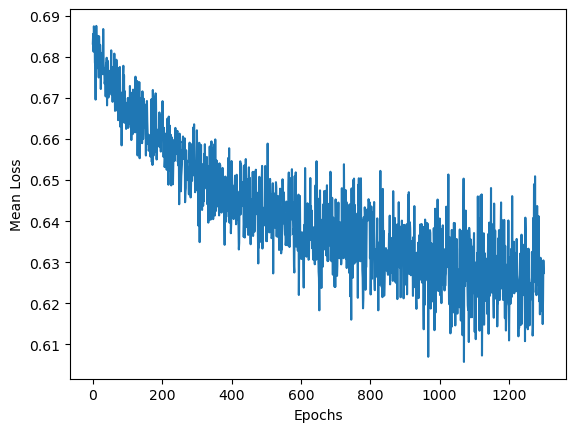

 26%|█████████                          | 1301/5000 [3:15:16<5:17:50,  5.16s/it]

Epoch: 1300, Loss: 0.6273616552352905


 28%|█████████▊                         | 1400/5000 [3:23:15<4:51:39,  4.86s/it]

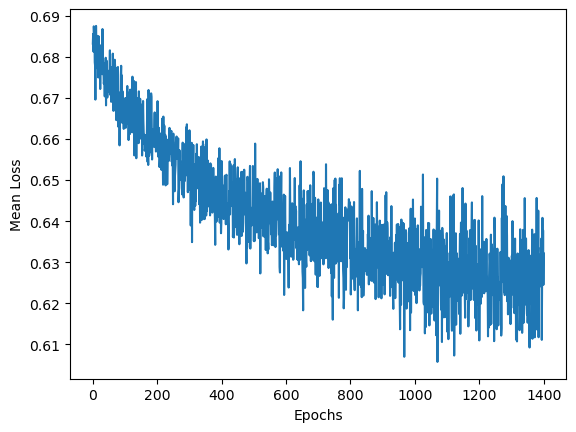

 28%|█████████▊                         | 1401/5000 [3:23:20<4:51:07,  4.85s/it]

Epoch: 1400, Loss: 0.632145345211029


 30%|██████████▌                        | 1500/5000 [3:31:19<4:41:41,  4.83s/it]

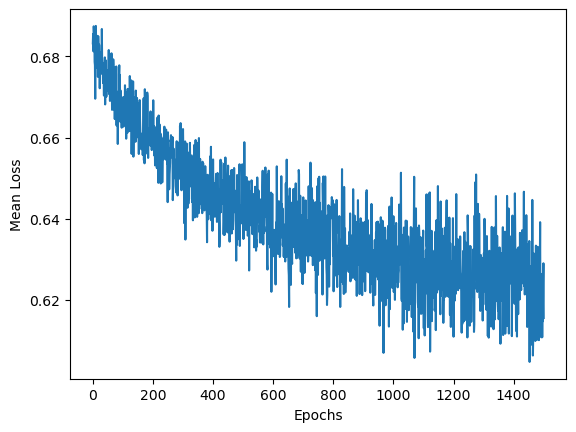

 30%|██████████▌                        | 1501/5000 [3:31:24<4:44:00,  4.87s/it]

Epoch: 1500, Loss: 0.6155780553817749


 32%|███████████▏                       | 1600/5000 [3:39:22<4:32:17,  4.81s/it]

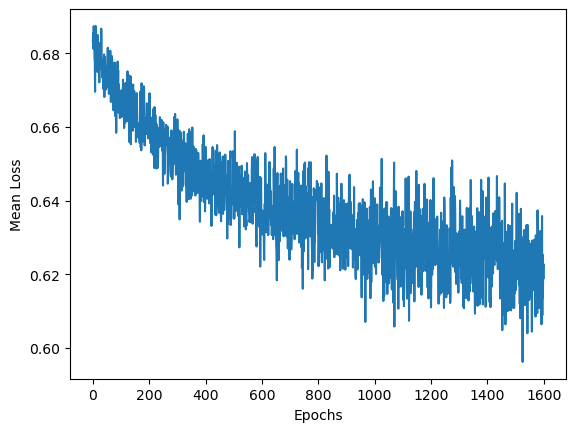

 32%|███████████▏                       | 1601/5000 [3:39:27<4:32:15,  4.81s/it]

Epoch: 1600, Loss: 0.6189212203025818


 34%|███████████▉                       | 1700/5000 [3:47:27<4:29:21,  4.90s/it]

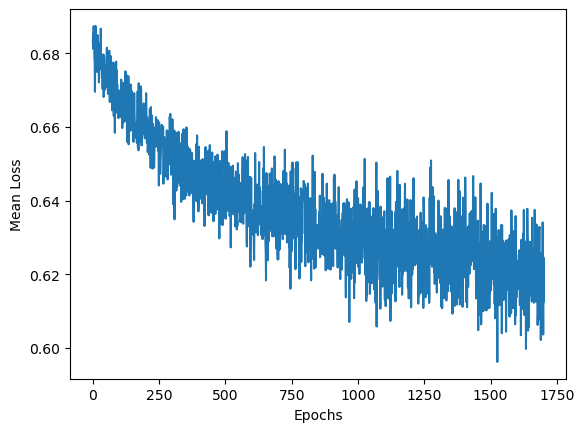

 34%|███████████▉                       | 1701/5000 [3:47:32<4:29:25,  4.90s/it]

Epoch: 1700, Loss: 0.6125959157943726


 36%|████████████▌                      | 1800/5000 [3:55:30<4:16:31,  4.81s/it]

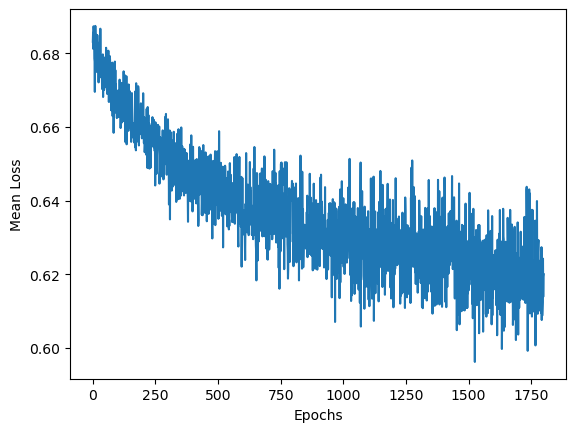

 36%|████████████▌                      | 1801/5000 [3:55:35<4:18:46,  4.85s/it]

Epoch: 1800, Loss: 0.6199706792831421


 38%|█████████████▎                     | 1900/5000 [4:03:34<4:11:01,  4.86s/it]

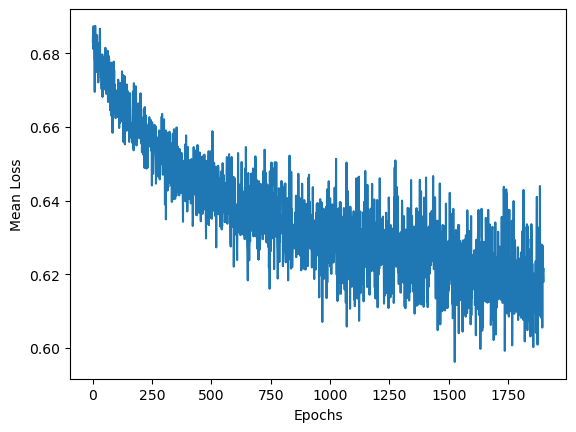

 38%|█████████████▎                     | 1901/5000 [4:03:38<4:10:05,  4.84s/it]

Epoch: 1900, Loss: 0.618057370185852


 40%|██████████████                     | 2000/5000 [4:11:39<4:00:54,  4.82s/it]

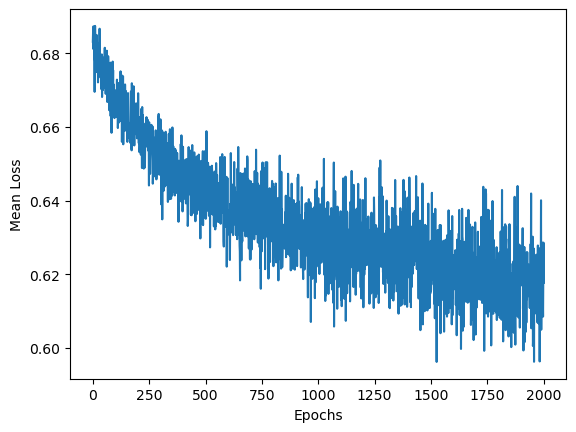

 40%|██████████████                     | 2001/5000 [4:11:44<4:02:17,  4.85s/it]

Epoch: 2000, Loss: 0.6176480650901794


 42%|██████████████▋                    | 2100/5000 [4:19:43<3:53:59,  4.84s/it]

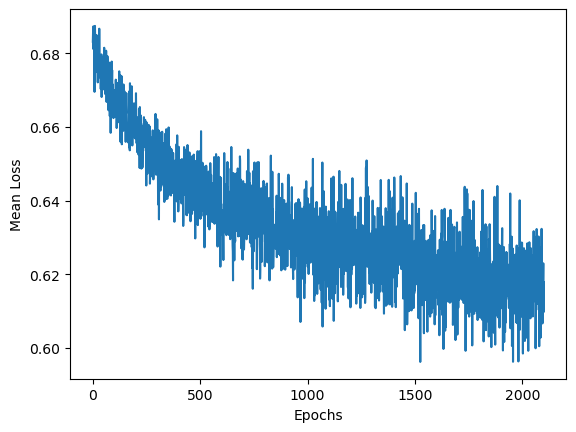

 42%|██████████████▋                    | 2101/5000 [4:19:48<3:55:03,  4.87s/it]

Epoch: 2100, Loss: 0.6177958846092224


 44%|███████████████▍                   | 2200/5000 [4:27:49<3:51:43,  4.97s/it]

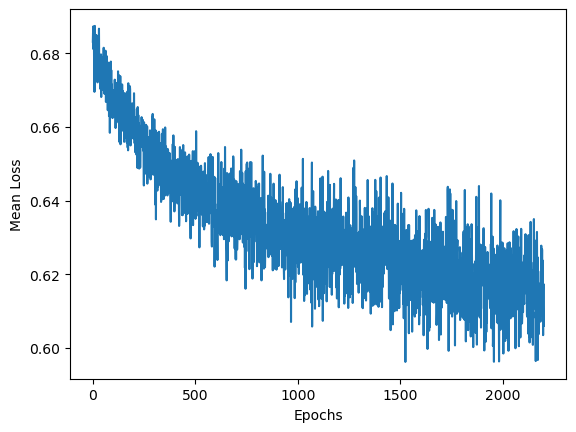

 44%|███████████████▍                   | 2201/5000 [4:27:54<3:53:41,  5.01s/it]

Epoch: 2200, Loss: 0.6059403419494629


 46%|████████████████                   | 2300/5000 [4:35:55<3:36:51,  4.82s/it]

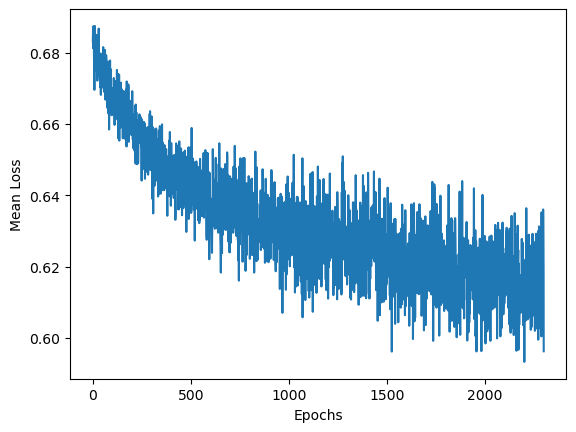

 46%|████████████████                   | 2301/5000 [4:35:59<3:36:13,  4.81s/it]

Epoch: 2300, Loss: 0.5962377190589905


 48%|████████████████▊                  | 2400/5000 [4:43:59<3:26:51,  4.77s/it]

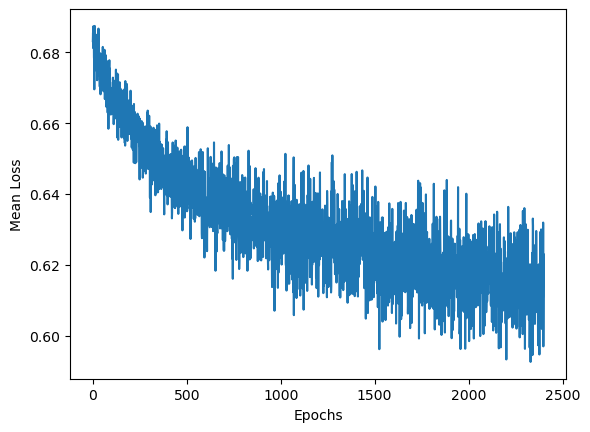

 48%|████████████████▊                  | 2401/5000 [4:44:04<3:29:52,  4.85s/it]

Epoch: 2400, Loss: 0.6228837370872498


 50%|█████████████████▌                 | 2500/5000 [4:52:03<3:22:35,  4.86s/it]

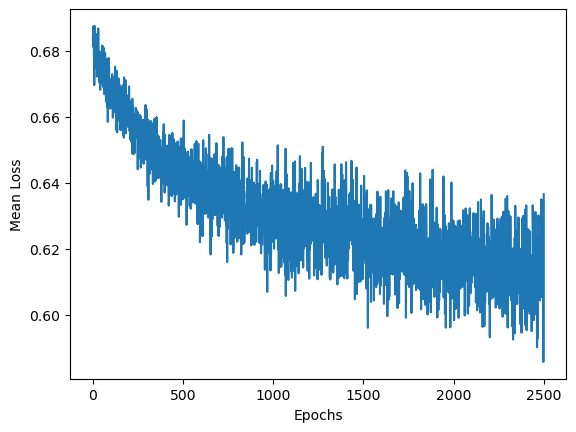

 50%|█████████████████▌                 | 2501/5000 [4:52:08<3:21:59,  4.85s/it]

Epoch: 2500, Loss: 0.6365732550621033


 52%|██████████████████▏                | 2600/5000 [5:00:07<3:13:32,  4.84s/it]

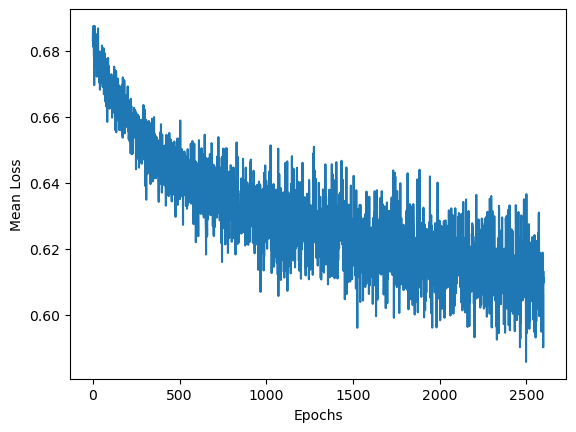

 52%|██████████████████▏                | 2601/5000 [5:00:12<3:12:55,  4.83s/it]

Epoch: 2600, Loss: 0.612967848777771


 54%|██████████████████▉                | 2700/5000 [5:08:11<3:04:31,  4.81s/it]

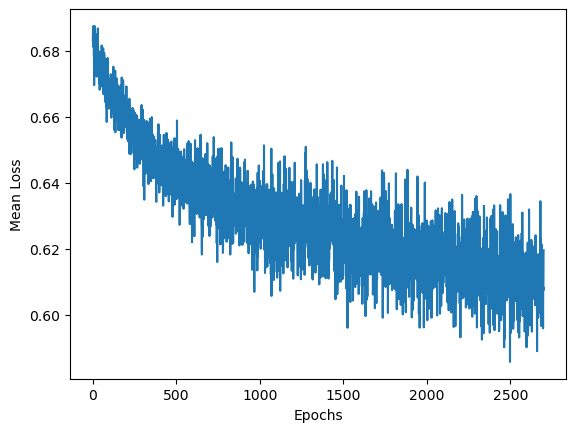

 54%|██████████████████▉                | 2701/5000 [5:08:16<3:06:11,  4.86s/it]

Epoch: 2700, Loss: 0.6195424199104309


 56%|███████████████████▌               | 2800/5000 [5:16:15<2:56:46,  4.82s/it]

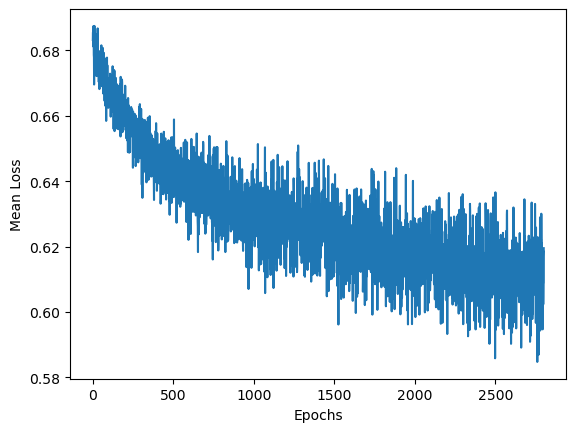

 56%|███████████████████▌               | 2801/5000 [5:16:21<2:59:36,  4.90s/it]

Epoch: 2800, Loss: 0.619493305683136


 58%|████████████████████▎              | 2900/5000 [5:24:21<2:50:19,  4.87s/it]

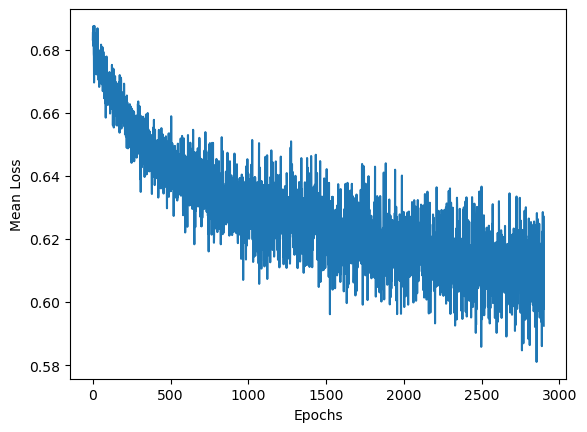

 58%|████████████████████▎              | 2901/5000 [5:24:26<2:51:16,  4.90s/it]

Epoch: 2900, Loss: 0.5925015211105347


 60%|█████████████████████              | 3000/5000 [5:32:28<2:43:31,  4.91s/it]

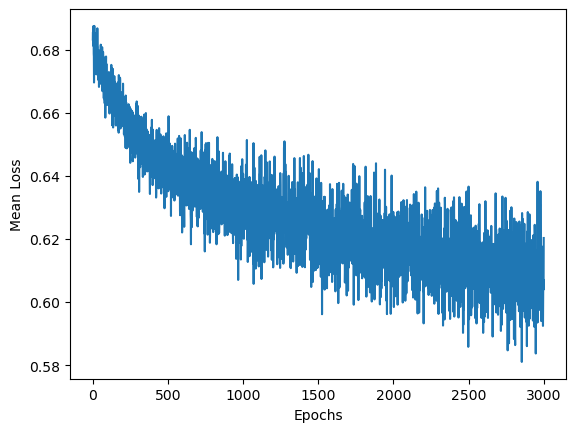

 60%|█████████████████████              | 3001/5000 [5:32:33<2:44:11,  4.93s/it]

Epoch: 3000, Loss: 0.6202894449234009


 62%|█████████████████████▋             | 3100/5000 [5:40:36<2:37:17,  4.97s/it]

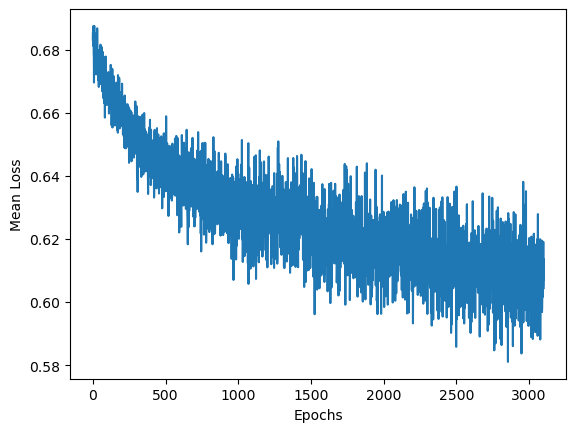

 62%|█████████████████████▋             | 3101/5000 [5:40:41<2:35:57,  4.93s/it]

Epoch: 3100, Loss: 0.6044213175773621


 64%|██████████████████████▍            | 3200/5000 [5:48:41<2:25:54,  4.86s/it]

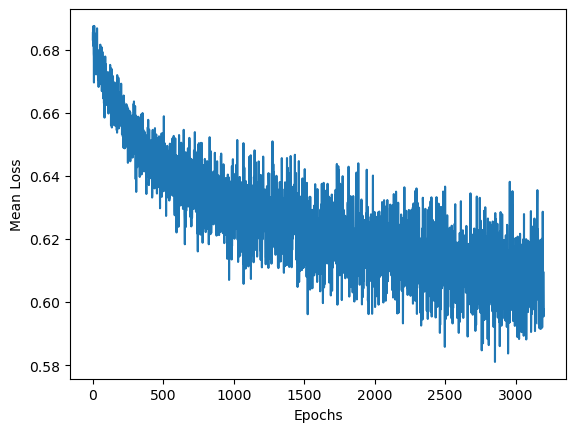

 64%|██████████████████████▍            | 3201/5000 [5:48:46<2:27:08,  4.91s/it]

Epoch: 3200, Loss: 0.5977084636688232


 66%|███████████████████████            | 3300/5000 [5:56:47<2:18:23,  4.88s/it]

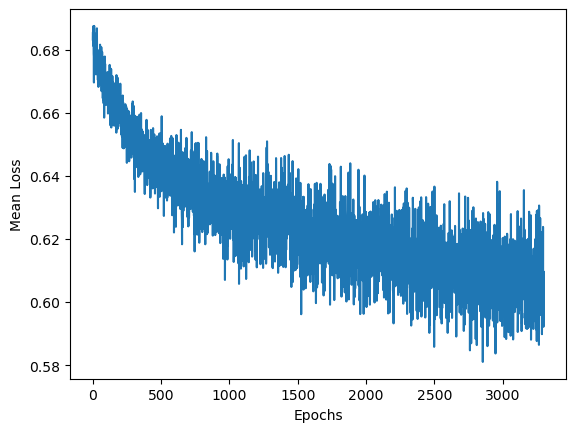

 66%|███████████████████████            | 3301/5000 [5:56:52<2:20:00,  4.94s/it]

Epoch: 3300, Loss: 0.6026356816291809


 68%|███████████████████████▊           | 3400/5000 [6:04:55<2:10:59,  4.91s/it]

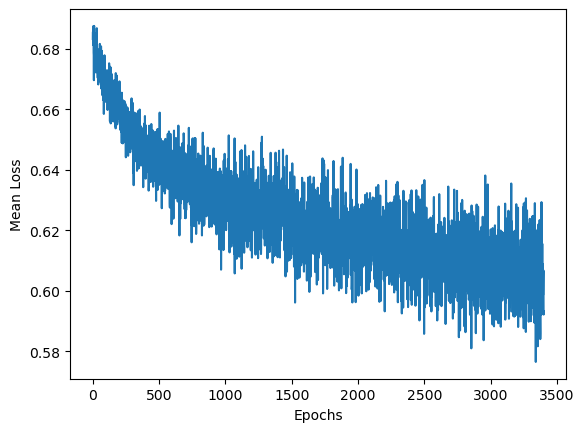

 68%|███████████████████████▊           | 3401/5000 [6:04:59<2:10:26,  4.89s/it]

Epoch: 3400, Loss: 0.5932159423828125


 70%|████████████████████████▌          | 3500/5000 [6:13:01<2:02:02,  4.88s/it]

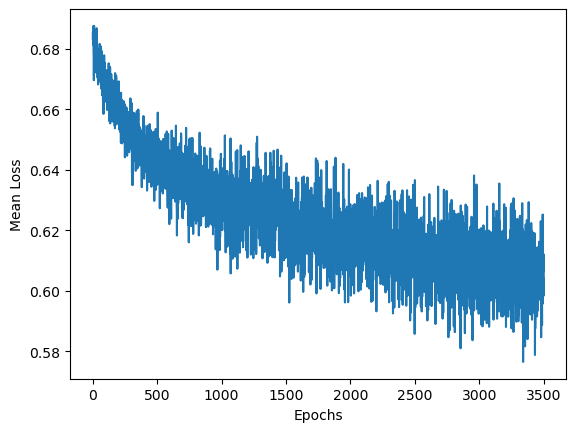

 70%|████████████████████████▌          | 3501/5000 [6:13:06<2:03:34,  4.95s/it]

Epoch: 3500, Loss: 0.6065553426742554


 72%|█████████████████████████▏         | 3600/5000 [6:21:09<1:55:17,  4.94s/it]

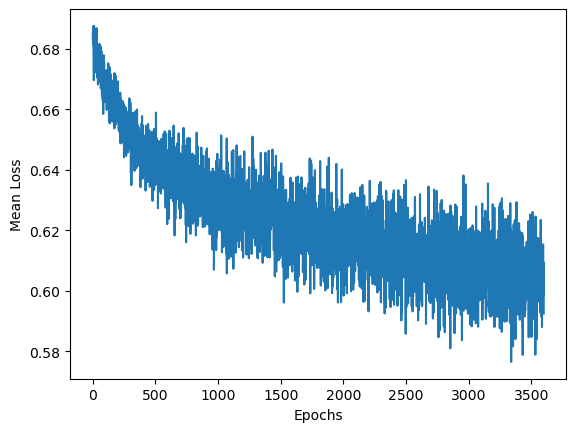

 72%|█████████████████████████▏         | 3601/5000 [6:21:14<1:55:14,  4.94s/it]

Epoch: 3600, Loss: 0.5925372838973999


 74%|█████████████████████████▉         | 3700/5000 [6:29:17<1:45:50,  4.88s/it]

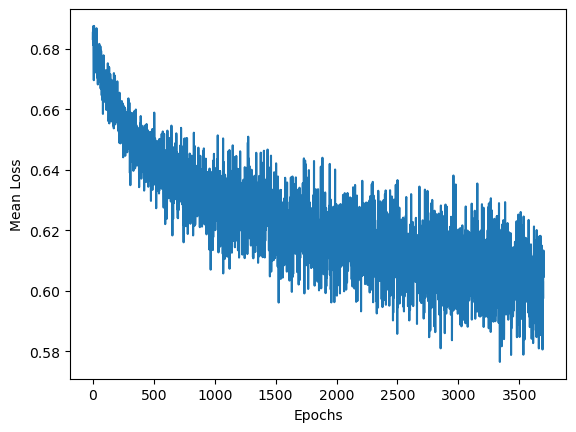

 74%|█████████████████████████▉         | 3701/5000 [6:29:22<1:47:01,  4.94s/it]

Epoch: 3700, Loss: 0.6067534685134888


 76%|██████████████████████████▌        | 3800/5000 [6:37:28<1:42:01,  5.10s/it]

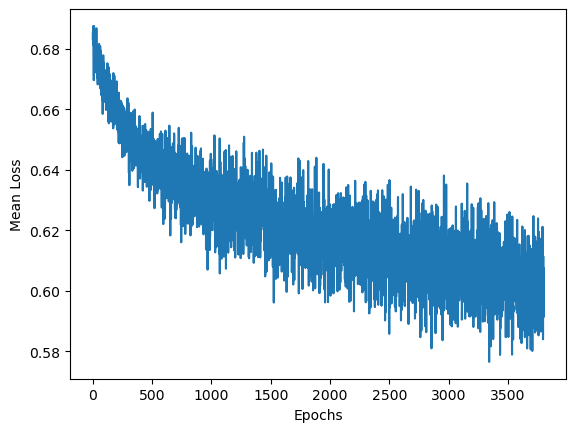

 76%|██████████████████████████▌        | 3801/5000 [6:37:33<1:41:32,  5.08s/it]

Epoch: 3800, Loss: 0.6073673963546753


 78%|███████████████████████████▎       | 3900/5000 [6:45:40<1:29:56,  4.91s/it]

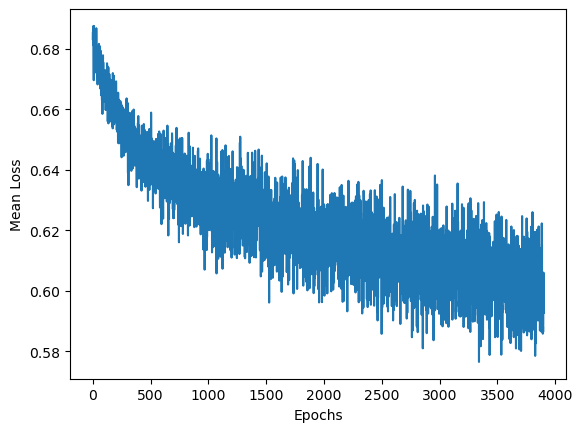

 78%|███████████████████████████▎       | 3901/5000 [6:45:44<1:29:30,  4.89s/it]

Epoch: 3900, Loss: 0.5927574038505554


 80%|████████████████████████████       | 4000/5000 [6:53:47<1:21:17,  4.88s/it]

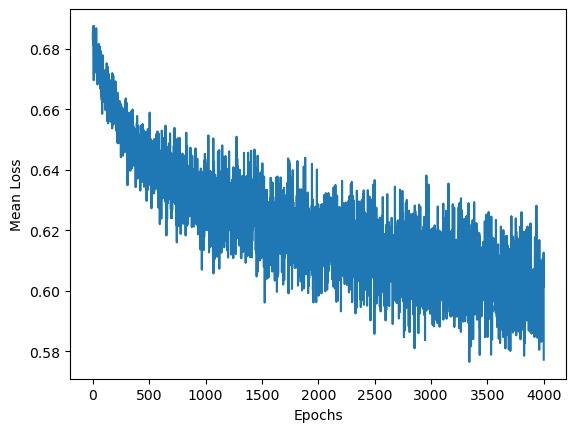

 80%|████████████████████████████       | 4001/5000 [6:53:51<1:20:54,  4.86s/it]

Epoch: 4000, Loss: 0.5772736072540283


 82%|████████████████████████████▋      | 4100/5000 [7:02:04<1:15:03,  5.00s/it]

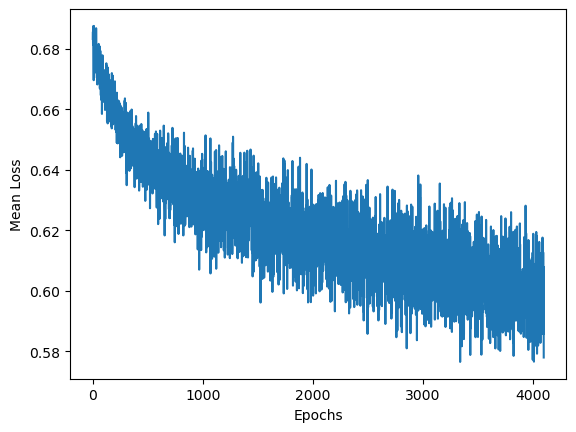

 82%|████████████████████████████▋      | 4101/5000 [7:02:09<1:15:03,  5.01s/it]

Epoch: 4100, Loss: 0.5780079960823059


 84%|█████████████████████████████▍     | 4200/5000 [7:10:36<1:08:12,  5.12s/it]

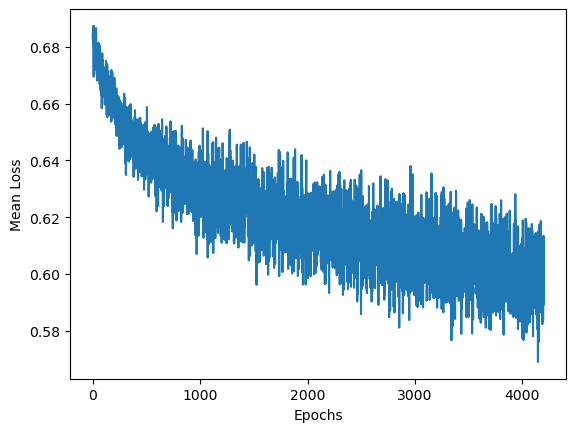

 84%|█████████████████████████████▍     | 4201/5000 [7:10:42<1:09:42,  5.23s/it]

Epoch: 4200, Loss: 0.5979301929473877


 86%|███████████████████████████████▊     | 4300/5000 [7:19:07<59:34,  5.11s/it]

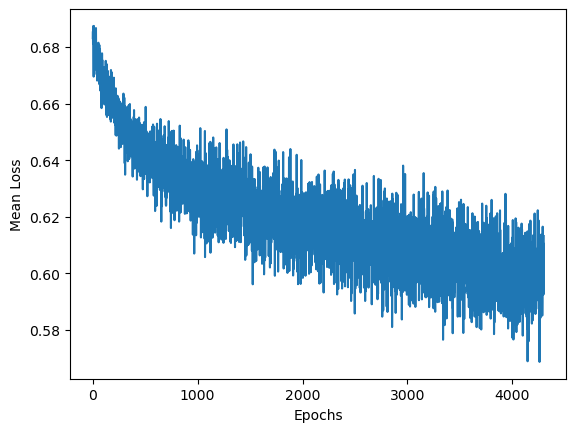

 86%|███████████████████████████████▊     | 4301/5000 [7:19:12<59:56,  5.14s/it]

Epoch: 4300, Loss: 0.6132066249847412


 88%|████████████████████████████████▌    | 4400/5000 [7:27:24<48:29,  4.85s/it]

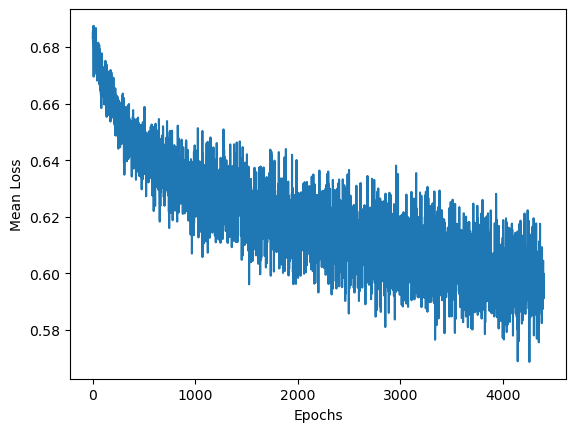

 88%|████████████████████████████████▌    | 4401/5000 [7:27:29<48:41,  4.88s/it]

Epoch: 4400, Loss: 0.5913236141204834


 90%|█████████████████████████████████▎   | 4500/5000 [7:35:33<40:48,  4.90s/it]

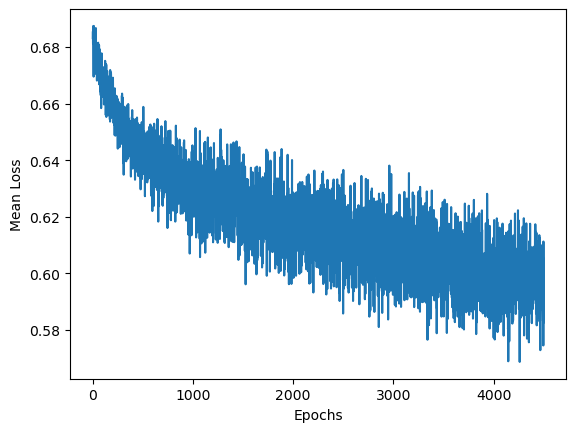

 90%|█████████████████████████████████▎   | 4501/5000 [7:35:38<40:37,  4.88s/it]

Epoch: 4500, Loss: 0.5827510952949524


 92%|██████████████████████████████████   | 4600/5000 [7:44:41<40:43,  6.11s/it]

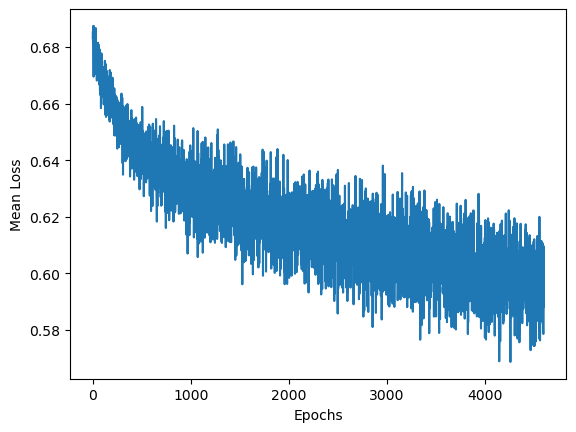

 92%|██████████████████████████████████   | 4601/5000 [7:44:47<40:30,  6.09s/it]

Epoch: 4600, Loss: 0.5881733894348145


 94%|██████████████████████████████████▊  | 4700/5000 [7:54:37<27:48,  5.56s/it]

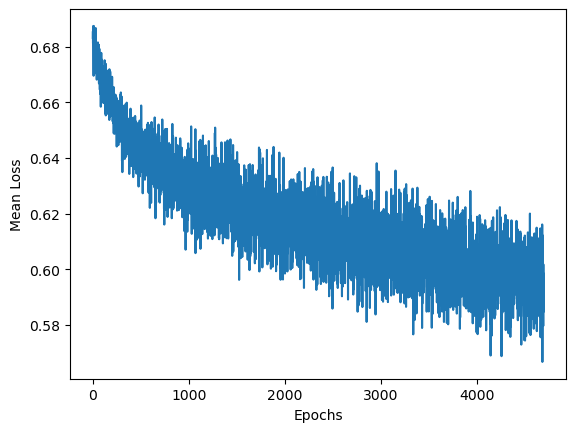

 94%|██████████████████████████████████▊  | 4701/5000 [7:54:43<28:47,  5.78s/it]

Epoch: 4700, Loss: 0.5848416090011597


 96%|███████████████████████████████████▌ | 4800/5000 [8:05:37<19:17,  5.79s/it]

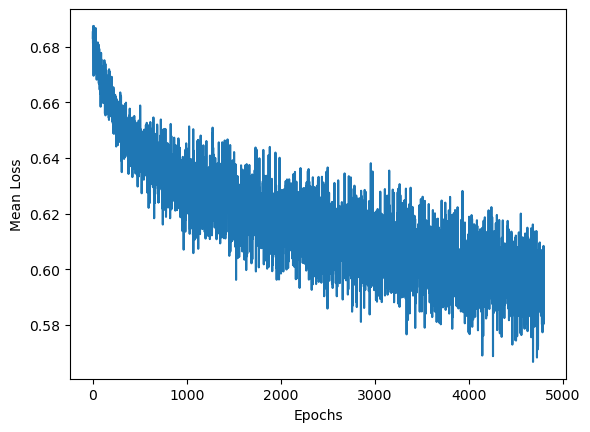

 96%|███████████████████████████████████▌ | 4801/5000 [8:05:44<19:46,  5.96s/it]

Epoch: 4800, Loss: 0.6078708171844482


 98%|████████████████████████████████████▎| 4900/5000 [8:15:42<09:28,  5.68s/it]

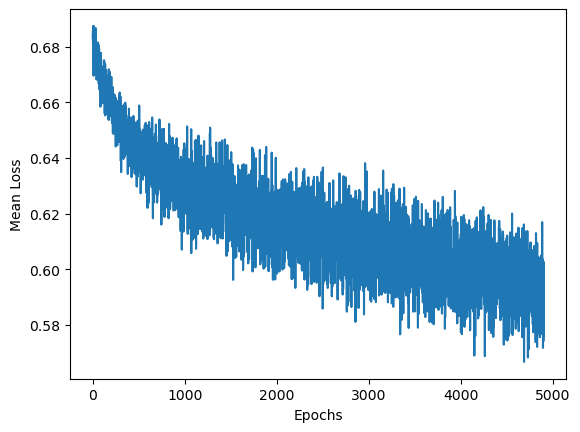

 98%|████████████████████████████████████▎| 4901/5000 [8:15:49<09:49,  5.96s/it]

Epoch: 4900, Loss: 0.5743541121482849


100%|█████████████████████████████████████| 5000/5000 [8:27:01<00:00,  6.08s/it]


In [37]:
model.train(X, y, task_lengths, 5000)

In [ ]:
test = pd.DataFrame()
for name in os.listdir("../datasets/mw_valid"):
    if not (name.startswith('.')):
        dir_name = 'mw_valid/'+name
        print(dir_name)
        df = read_file(dir_name)
        test = pd.concat([data, df])

test.reset_index(drop=True, inplace=True)
Test = PreferenceMAML(test, input_size, hidden_size1, hidden_size2, output_size)
test_X, test_y = Test.prepare_data(k=4)


# Evaluate the model on the test set
def evaluate_model(model, X, y):
    predictions = []
    with torch.no_grad():
        for i in range(len(X)):
            X_tensor = torch.tensor(X[i], dtype=torch.float32)
            output = model.model(X_tensor.unsqueeze(0))  
            predictions.append(output.squeeze().numpy())  

    preds = []
    for _ in range(len(predictions)):
        preds.append((np.array(predictions[_]).mean()))

    pred_label = []
    for i in range(len(preds)):
        pred_label.append([0] if preds[i]>0.5 else [1])
    
    sum = 0
    for _ in range(len(y)):
        sum += pred_label[_]==y[_]
    accuracy = sum/len(y)
    return accuracy, pred_label

test_accuracy, pred_labels = evaluate_model(model, test_X, test_y)
print(f'\nTest Accuracy: {test_accuracy}')

### Without INNER LOOP

In [ ]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes



#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]


#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):

#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis = 1))
#                 y.append([self.compare_probabilities(sigma1, sigma2)]) 

#         return X, y


#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in range(len(X)):
#             loss = self._compute_loss(X[i], y[i])
#             outer_losses.append(loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _compute_loss(self, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_tensor = torch.tensor([y], dtype=torch.float32)
#         output = self.model(X_tensor)
#         output_flat = output.view(-1)
#         y_flat = y_tensor.view(-1)
#         loss = self.reward_criterion(output_flat[-2:], y_flat)
#         return loss

# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 20

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": 0.005})

# X, y = model.prepare_data(k=4)

# # Train the model
# for epoch in range(num_epochs):
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")


### With INNER LOOP but Improper classification

In [ ]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         inner_lr = 0.01,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps
#         self.inner_lr = inner_lr

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes

#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]

#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):
#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis=1))
#                 y.append(self.compare_probabilities(sigma1, sigma2))

#         return X, y

#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in tqdm(range(len(X))):
#             if len(X[i])>self.num_support:
#                 support_X, support_y, query_X, query_y = self._split_support_query(X[i], y[i])
#                 # Inner loop (adaptation)
#                 adapted_model = self._inner_loop(support_X, support_y)
#                 # Compute loss using the adapted model on query set
#                 query_loss = self._compute_loss(adapted_model, query_X, query_y)
#                 outer_losses.append(query_loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _inner_loop(self, support_X, support_y):
#         adapted_model = Model(self.model.fc1.in_features, self.model.fc1.out_features,
#                               self.model.fc2.out_features, self.model.fc3.out_features)
#         adapted_model.load_state_dict(self.model.state_dict())

#         inner_optimizer = optim.Adam(adapted_model.parameters(), lr=self.inner_lr)

#         for _ in range(self.num_inner_steps):
#             inner_optimizer.zero_grad()
#             loss = self._compute_loss(adapted_model, support_X, support_y)
#             print(loss)
#             loss.backward()
#             inner_optimizer.step()

#         return adapted_model

#     def _compute_loss(self, model, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_class = [0 if y[i]==[1,0] else 1 for i in range(len(y))]
#         y_tensor = torch.tensor(y_class, dtype=torch.long)  # Assuming y is class indices
#         output = model(X_tensor)

#         loss = self.reward_criterion(output, y_tensor)
#         return loss

#     def _split_support_query(self, X, y):
#         num_samples = len(X)
#         all_indices = np.arange(num_samples)
#         # Randomly sample support indices
#         support_indices = np.random.choice(num_samples, self.num_support, replace=False)
#         query_indices = np.setdiff1d(all_indices, support_indices)
#         support_X = X[support_indices]
#         query_X = X[query_indices]
#         # For y, we can simply use the same indices as for X, as it has a fixed length of 2
#         support_y = [y] * self.num_support
#         query_y = [y] * len(query_indices)

#         return support_X, support_y, query_X, query_y


# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 5
# outer_lr = 0.001

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": outer_lr})

# print('Preparing Data.')
# # X, y = model.prepare_data(k=4)
# print('Data Preparation Done.\n')

# # Train the model
# for epoch in range(num_epochs):
#     print(f'\nBeginning Training - Epoch [{epoch+1}/{num_epochs}]')
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")
